### Load dependencies

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import h5py




# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-05-17 16:27:53.249763: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 16:27:53.283498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 16:27:53.283528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 16:27:53.284715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 16:27:53.290752: I tensorflow/core/platform/cpu_feature_guar

### Data Loading and processing

In [2]:
with h5py.File('TrainingData5zeroes midpoints.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    # boxes = hdf.get('boxes')
    center_coordinates = hdf.get('center_coordinates')
    images = np.array(images)
    # boxes = np.array(boxes)
    center_coordinates = np.array(center_coordinates)

image_normalized = (images + 1e-9) / 9.26
# normalized_boxes = boxes / [1, 64, 64, 64, 64]

images_np = image_normalized
center_coordinates = center_coordinates / [1,64, 64]  # Normalizing the center coordinates
probabilities = np.array(center_coordinates[:,:, :-2])
probabilities = tf.expand_dims(probabilities, axis=1)
center_coordinates_np = np.array(center_coordinates[:, :, 1:])
center_coordinates_np = tf.expand_dims(center_coordinates_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
# dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)
total_items = len(images_np)
train_size = int(total_items * 0.6)
test_size = total_items - train_size 

    # Splitting the dataset
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)


train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size) 

2024-05-17 16:28:04.055224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21827 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


### Model Definition

In [3]:
input_shape = (64, 64, 1)
num_classes = 280
num_coordinates = 2


x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)

#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)

#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




model = tf.keras.models.Model(x_input, [x_prob_reshape, x_midpoints_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_midpoints_reshape':tf.keras.losses.MeanSquaredError()}, metrics=['accuracy'])    
# num_epochs = 2500

Load Trained weights

In [4]:

loadedmodel = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/midpoint3.keras")

### Make Predictions

In [5]:

dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
test_dataset = dataset.take(test_size)
test_dataset = test_dataset.batch(test_size)
inputs,targets = next(iter(test_dataset))
output =loadedmodel.predict(inputs)

2024-05-17 16:30:17.321178: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-17 16:30:17.411623: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 15/125 [==>...........................] - ETA: 0s

2024-05-17 16:30:17.766848: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


125/125 [==============================] - 2s 8ms/step


### Manual Loss Calculation

In [7]:
import tensorflow as tf

r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_midpoints_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[1], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = tf.keras.losses.MeanSquaredError()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())

MSE Loss: 3.12054250566933e-05


Conversion From Regression to Classification

### Visualisation

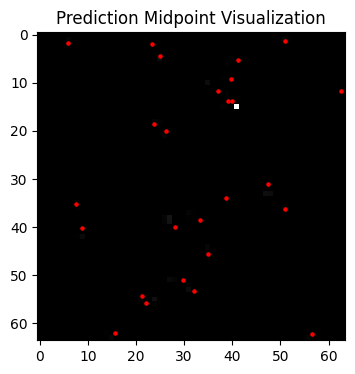

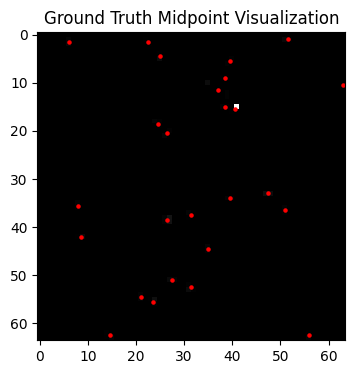

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Prediction Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(x, y, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()

t = np.random.randint(0,2000)

visualize_midpoints(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction 

def visualize_midpoints2(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(x, y, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()     
visualize_midpoints2(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64]) ##myprediction           




### Model Evaluation

In [8]:
import numpy as np

def evaluate_model(predictions, ground_truths, probability_threshold=0.9, midpoint_diff_threshold=0.1):
    pred_probabilities = predictions[0]
    pred_midpoints = predictions[1]
    gt_probabilities = ground_truths[0]
    gt_midpoints = ground_truths[1]
    
    # Valid predictions are those above the probability threshold
    valid_predictions = pred_probabilities > probability_threshold
    no_predictions = pred_probabilities <= probability_threshold

    # Calculate differences for midpoint evaluations
    midpoint_diff = np.abs(pred_midpoints - gt_midpoints)
    is_accurate_prediction = np.all(midpoint_diff <= midpoint_diff_threshold, axis=1)
    
    # True Positives: Valid predictions close enough to the ground truth
    TP = np.sum(np.logical_and(valid_predictions, is_accurate_prediction))
    
    # False Positives: Valid predictions not close enough to the ground truth
    FP = np.sum(np.logical_and(valid_predictions, ~is_accurate_prediction))
    
    # True Negatives: No predictions where no objects are actually present
    TN = np.sum(np.logical_and(no_predictions, gt_probabilities <= probability_threshold))
    
    # False Negatives: No predictions where objects are actually present
    FN = np.sum(np.logical_and(no_predictions, gt_probabilities > probability_threshold))
    
    # Metrics calculation
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    MAE = np.mean(midpoint_diff)
    
    return precision, recall, F1_score, MAE

# Usage example
predictions = [output[0], output[1]]
ground_truths = [targets['x_prob_reshape'], targets['x_midpoints_reshape']]
precision, recall, F1_score, MAE = evaluate_model(predictions, ground_truths)

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {F1_score}, MAE: {MAE}")


Precision: 0.9999990876750643, Recall: 1.0, F1 Score: 0.999999543837324, MAE: 0.0020188948805420185
